<a href="https://colab.research.google.com/github/cod3astro/kaggle_ML_competition/blob/main/loan_payback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore', message=".*X does not have valid feature names.*")

In [3]:
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')
train.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
id,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [4]:
train.shape

(593994, 12)

In [5]:
train.isnull().any().any()

np.False_

In [6]:
train.describe(include='all')

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994,593994,593994,593994,593994,593994,593994.000000
unique,NaN,NaN,NaN,NaN,NaN,3,4,5,5,8,30,NaN
top,NaN,NaN,NaN,NaN,NaN,Female,Single,Bachelor's,Employed,Debt consolidation,C3,NaN
freq,NaN,NaN,NaN,NaN,NaN,306175,288843,279606,450645,324695,58695,NaN
mean,48212.202976,0.120696,680.916009,15020.297629,12.356345,NaN,NaN,NaN,NaN,NaN,NaN,0.798820
std,26711.942078,0.068573,55.424956,6926.530568,2.008959,NaN,NaN,NaN,NaN,NaN,NaN,0.400883
min,6002.430000,0.011000,395.000000,500.090000,3.200000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,27934.400000,0.072000,646.000000,10279.620000,10.990000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,46557.680000,0.096000,682.000000,15000.220000,12.370000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,60981.320000,0.156000,719.000000,18858.580000,13.680000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [7]:
def create_derived_features(df):
    df = train.copy()
    print(f"Processing dataset shape: {df.shape}")

    # 1. Rounding Features
    # This reduces noise by grouping similar values
    for col in ['annual_income', 'loan_amount']:
        if col in df.columns:
            # Round to nearest whole number (1s)
            df[f'{col}_ROUND_1s'] = df[col].round(0).astype(int)
            # Round to nearest ten (10s)
            df[f'{col}_ROUND_10s'] = df[col].round(-1).astype(int)
            print(f"  -> Created rounding features for {col}")

    # 2. Subgrade and Grade Extraction
    # Splits "B2" into Grade "B" and Subgrade "2"
    if 'grade_subgrade' in df.columns:
        df['grade'] = df['grade_subgrade'].str[0]
        # taking the rest of the string and converting to int
        df['subgrade'] = df['grade_subgrade'].str[1:].astype(int)
        print(f"  -> Extracted grade and subgrade")

    # 3. Total Debt Burden Calculation
    # Formula: (Loan Amount * Interest Rate) / Annual Income
    req_cols = ['loan_amount', 'interest_rate', 'annual_income']
    if all(col in df.columns for col in req_cols):
        df['total_debt_burden'] = (
            (df['loan_amount'] * df['interest_rate'] / 100) /
            (df['annual_income'] + 1) # +1 prevents division by zero error
        )
        print(f"  -> Calculated total_debt_burden")

    return df

# --- EXECUTION ---
print("STEP 1: Creating Derived Features...")

# Apply to Train Data
df = create_derived_features(train)

print("\nDone! Check your dataframe head to see new columns.")

STEP 1: Creating Derived Features...
Processing dataset shape: (593994, 12)
  -> Created rounding features for annual_income
  -> Created rounding features for loan_amount
  -> Extracted grade and subgrade
  -> Calculated total_debt_burden

Done! Check your dataframe head to see new columns.


In [8]:
df.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,annual_income_ROUND_1s,annual_income_ROUND_10s,loan_amount_ROUND_1s,loan_amount_ROUND_10s,grade,subgrade,total_debt_burden
id,,,,,,,,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0,29368,29370,2528,2530,C,3,0.011769
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0,22108,22110,4593,4590,D,3,0.026841
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0,49566,49570,17005,17010,C,5,0.033484
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0,46858,46860,4682,4680,F,1,0.016088
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0,25497,25500,12184,12180,D,1,0.048790


In [9]:
def create_derived_features(test_df):
    test_df = test.copy()
    print(f"Processing dataset shape: {test_df.shape}")

    # 1. Rounding Features
    # This reduces noise by grouping similar values
    for col in ['annual_income', 'loan_amount']:
        if col in test_df.columns:
            # Round to nearest whole number (1s)
            test_df[f'{col}_ROUND_1s'] = test_df[col].round(0).astype(int)
            # Round to nearest ten (10s)
            test_df[f'{col}_ROUND_10s'] = test_df[col].round(-1).astype(int)
            print(f"  -> Created rounding features for {col}")

    # 2. Subgrade and Grade Extraction
    # Splits "B2" into Grade "B" and Subgrade "2"
    if 'grade_subgrade' in test_df.columns:
        test_df['grade'] = test_df['grade_subgrade'].str[0]
        # taking the rest of the string and converting to int
        test_df['subgrade'] = test_df['grade_subgrade'].str[1:].astype(int)
        print(f"  -> Extracted grade and subgrade")

    # 3. Total Debt Burden Calculation
    # Formula: (Loan Amount * Interest Rate) / Annual Income
    req_cols = ['loan_amount', 'interest_rate', 'annual_income']
    if all(col in test_df.columns for col in req_cols):
        test_df['total_debt_burden'] = (
            (test_df['loan_amount'] * test_df['interest_rate'] / 100) /
            (test_df['annual_income'] + 1) # +1 prevents division by zero error
        )
        print(f"  -> Calculated total_debt_burden")

    return test_df

# --- EXECUTION ---
print("STEP 1: Creating Derived Features...")
test_df = create_derived_features(test)

print("\nDone! Check your dataframe head to see new columns.")

STEP 1: Creating Derived Features...
Processing dataset shape: (254569, 11)
  -> Created rounding features for annual_income
  -> Created rounding features for loan_amount
  -> Extracted grade and subgrade
  -> Calculated total_debt_burden

Done! Check your dataframe head to see new columns.


In [10]:
df.shape

(593994, 19)

In [11]:
test_df.shape

(254569, 18)

In [12]:
feature_list = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'grade']
target_Column = train['loan_paid_back']

In [13]:
from sklearn.model_selection import KFold

def apply_target_encoding(df, test_df, feature_list, target_column, n_folds=10):

    # Applies Target Encoding with K-Fold Cross-Validation to prevent data leakage.
    # Work on copies to avoid messing up original dfs
    train_encoded = df.copy()
    test_encoded = test_df.copy()

    # Setup K-Fold
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    print(f"Starting Target Encoding on {len(feature_list)} features...")

    for feature in feature_list:
        # Create a new column name, e.g., 'mean_grade'
        new_col_name = f'mean_{feature}'

        # Initialize the new column with zeros
        train_encoded[new_col_name] = 0.0

        # --- PART A: ENCODE TRAINING DATA (With K-Fold) ---
        # We split train data into chunks. We calculate means on 9 chunks
        # and apply them to the 1 chunk we left out.
        for train_idx, val_idx in kfold.split(train_encoded):
            # Get the rows for this fold
            train_X_fold = train_encoded.iloc[train_idx]
            val_X_fold = train_encoded.iloc[val_idx]

            # Calculate mean target for each category in this fold
            target_means = train_X_fold.groupby(feature)[target_column].mean()

            # Map these means to the validation chunk
            train_encoded.loc[val_idx, new_col_name] = val_X_fold[feature].map(target_means)

        # Fill any NaNs in train (rare categories) with the global mean
        global_mean = df[target_column].mean()
        train_encoded[new_col_name] = train_encoded[new_col_name].fillna(global_mean)

        # --- PART B: ENCODE TEST DATA ---
        # For test data, we just use the mean from the ENTIRE training set
        # (This is allowed because test data is "future" data)
        global_target_means = df.groupby(feature)[target_column].mean()
        test_encoded[new_col_name] = test_encoded[feature].map(global_target_means)

        # Fill NaNs in test with global mean
        test_encoded[new_col_name] = test_encoded[new_col_name].fillna(global_mean)

        print(f"  -> Created {new_col_name}")

    return train_encoded, test_encoded

# --- EXECUTION ---

# 1. Define which columns to encode
# (Make sure these exist in your dataframe!)
cols_to_encode = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'grade']

# 2. Check if columns actually exist before running
valid_cols = [c for c in cols_to_encode if c in df.columns]

# 3. Run the function
train_df, test_df = apply_target_encoding(
    df,
    test_df,
    valid_cols,
    target_column='loan_paid_back'
)

print("\nTarget Encoding Complete.")

Starting Target Encoding on 7 features...
  -> Created mean_gender
  -> Created mean_marital_status
  -> Created mean_education_level
  -> Created mean_employment_status
  -> Created mean_loan_purpose
  -> Created mean_grade_subgrade
  -> Created mean_grade

Target Encoding Complete.


In [14]:
train_df.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,...,grade,subgrade,total_debt_burden,mean_gender,mean_marital_status,mean_education_level,mean_employment_status,mean_loan_purpose,mean_grade_subgrade,mean_grade
id,,,,,,,,,,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,...,C,3,0.011769,0.801849,0.798620,0.809872,0.899373,0.802523,0.835599,0.847408
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,...,D,3,0.026841,0.795701,0.799062,0.801979,0.894310,0.796776,0.696667,0.715627
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,...,C,5,0.033484,0.795911,0.799196,0.809513,0.894361,0.797319,0.847187,0.847379
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,...,F,1,0.016088,0.801921,0.799147,0.809975,0.894136,0.797424,0.624315,0.625832
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,...,D,1,0.048790,0.795721,0.799128,0.809427,0.894031,0.802351,0.733585,0.715151


In [15]:
cols_to_drop = ['loan_amount_ROUND_1s', 'loan_amount_ROUND_10s', 'annual_income_ROUND_1s', 'annual_income_ROUND_10s']
df = train_df.drop(columns=cols_to_drop)
df.shape

(593994, 22)

In [16]:
numerical_col = df.select_dtypes(include=np.number).columns
numerical_col = numerical_col.drop('loan_paid_back')
skewness = df[numerical_col].skew().sort_values(ascending=False)

print("Skewness of numerical features:\n")
print(skewness)

Skewness of numerical features:

total_debt_burden         2.523318
annual_income             1.719509
debt_to_income_ratio      1.406680
mean_education_level      0.487781
mean_loan_purpose         0.245823
loan_amount               0.207360
interest_rate             0.049945
subgrade                  0.003695
mean_gender              -0.072208
credit_score             -0.166993
mean_grade               -0.255131
mean_grade_subgrade      -0.263204
mean_employment_status   -2.277686
mean_marital_status      -6.738070
dtype: float64


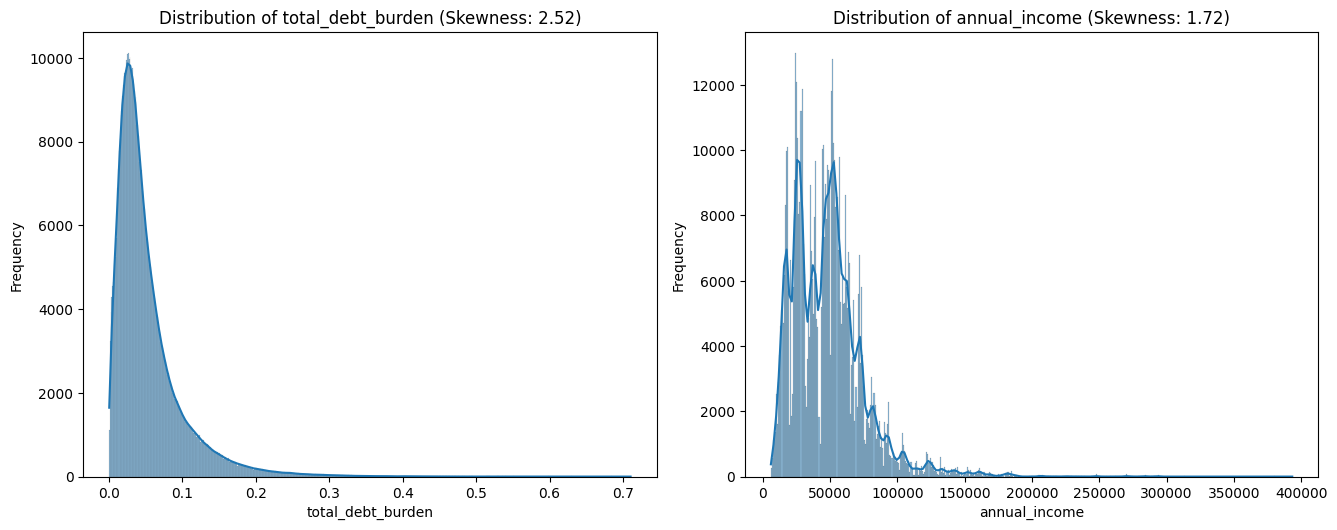

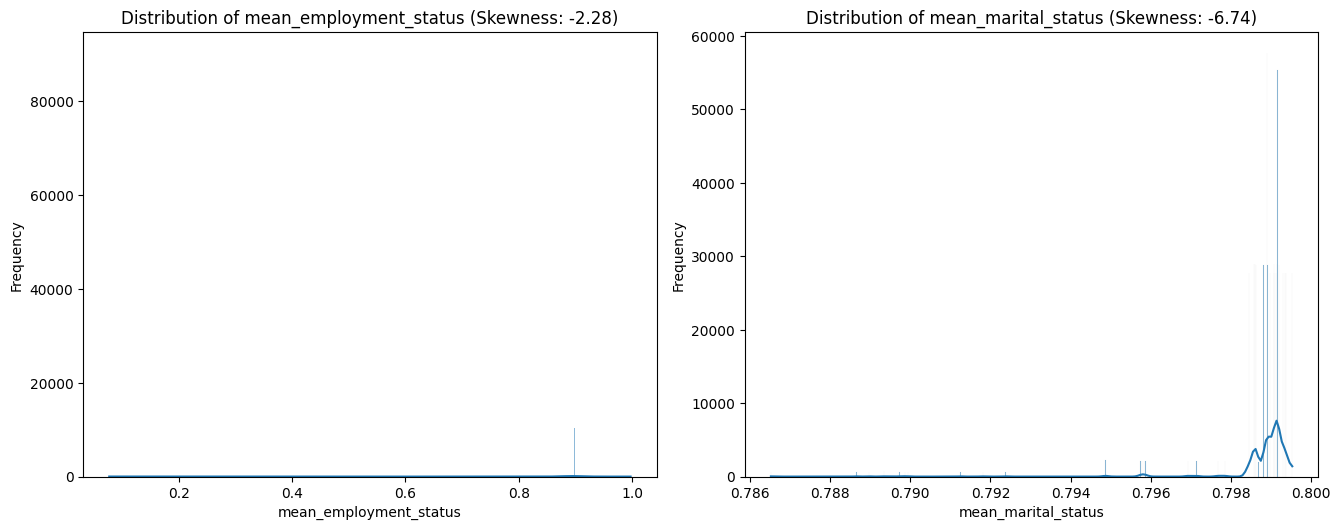

In [17]:
top_skewed_features = skewness.head(2).index
bottom_skewed_features = skewness.tail(2).index

def plot_skewness(columns):
    plt.figure(figsize=(20, 10))
    for i, col in enumerate(columns):
        plt.subplot(2, 3, i + 1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col} (Skewness: {skewness[col]:.2f})')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
plot_skewness(columns=top_skewed_features)
plot_skewness(columns=bottom_skewed_features)

In [18]:
#from scipy.stats import boxcox

# Reload df to revert previous transformations on 'debt_to_income_ratio'
# df = pd.read_csv('train.csv', index_col='id')

# Apply Box-Cox transformation to 'debt_to_income_ratio'
# Box-Cox requires data to be strictly positive. Check and ensure.
# for col in ['debt_to_income_ratio', 'annual_income']:
#    if (df[col] <= 0).any():
#        print("Warning:", col, "contains non-positive values. Box-Cox might not be suitable or requires adjustment.")

#    else:
#        df[col], lambda_val = boxcox(df[col])
#        print(f"Transformed skewness of debt_to_income_ratio (Box-Cox, lambda={lambda_val:.2f}): {df['debt_to_income_ratio'].skew():.2f}")


In [19]:
#transformed_features = ['annual_income', 'debt_to_income_ratio']

#plt.figure(figsize=(15, 6))
#for i, col in enumerate(transformed_features):
#    plt.subplot(1, 2, i + 1)
#    sns.histplot(df[col], kde=True)
#    plt.title(f'Distribution of Transformed {col} (Skewness: {df[col].skew():.2f})')
#    plt.xlabel(col)
#    plt.ylabel('Frequency')
#plt.tight_layout()
#plt.show()

In [20]:
categorical_col = df.select_dtypes(include='object').columns
for col in categorical_col:
    unique_values = df[col].unique()
    print(f'{col} ({len(unique_values)} unique)')
    print(df[col].unique())

gender (3 unique)
['Female' 'Male' 'Other']
marital_status (4 unique)
['Single' 'Married' 'Divorced' 'Widowed']
education_level (5 unique)
['High School' "Master's" "Bachelor's" 'PhD' 'Other']
employment_status (5 unique)
['Self-employed' 'Employed' 'Unemployed' 'Retired' 'Student']
loan_purpose (8 unique)
['Other' 'Debt consolidation' 'Home' 'Education' 'Vacation' 'Car'
 'Medical' 'Business']
grade_subgrade (30 unique)
['C3' 'D3' 'C5' 'F1' 'D1' 'D5' 'C2' 'C1' 'F5' 'D4' 'C4' 'D2' 'E5' 'B1'
 'B2' 'F4' 'A4' 'E1' 'F2' 'B4' 'E4' 'B3' 'E3' 'B5' 'E2' 'F3' 'A5' 'A3'
 'A1' 'A2']
grade (6 unique)
['C' 'D' 'F' 'E' 'B' 'A']


In [21]:
print(df.shape)

(593994, 22)


In [22]:
df['loan_paid_back'].value_counts(normalize=True)

,proportion
loan_paid_back,
1.0,0.79882
0.0,0.20118


In [23]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, NearMiss
from scipy.stats import pointbiserialr, chi2_contingency
from imblearn.pipeline import Pipeline as ImbPipeline

In [24]:
X = df.drop(columns=['loan_paid_back', 'grade'])
y_unflipped = df['loan_paid_back']
y = y_unflipped.map({1: 0, 0: 1})

In [25]:
X.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,subgrade,total_debt_burden,mean_gender,mean_marital_status,mean_education_level,mean_employment_status,mean_loan_purpose,mean_grade_subgrade,mean_grade
id,,,,,,,,,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,3,0.011769,0.801849,0.798620,0.809872,0.899373,0.802523,0.835599,0.847408
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,3,0.026841,0.795701,0.799062,0.801979,0.894310,0.796776,0.696667,0.715627
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,5,0.033484,0.795911,0.799196,0.809513,0.894361,0.797319,0.847187,0.847379
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1,0.016088,0.801921,0.799147,0.809975,0.894136,0.797424,0.624315,0.625832
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1,0.048790,0.795721,0.799128,0.809427,0.894031,0.802351,0.733585,0.715151


In [26]:
cat_cols = df.select_dtypes(object).columns
A = df.drop(columns=cat_cols)
A = A.drop(columns=['loan_paid_back'])
b_unflipped = df['loan_paid_back']
b = b_unflipped.map({1: 0, 0: 1})

In [27]:
A.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,subgrade,total_debt_burden,mean_gender,mean_marital_status,mean_education_level,mean_employment_status,mean_loan_purpose,mean_grade_subgrade,mean_grade
id,,,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,3,0.011769,0.801849,0.798620,0.809872,0.899373,0.802523,0.835599,0.847408
1,22108.02,0.166,636,4593.10,12.92,3,0.026841,0.795701,0.799062,0.801979,0.894310,0.796776,0.696667,0.715627
2,49566.20,0.097,694,17005.15,9.76,5,0.033484,0.795911,0.799196,0.809513,0.894361,0.797319,0.847187,0.847379
3,46858.25,0.065,533,4682.48,16.10,1,0.016088,0.801921,0.799147,0.809975,0.894136,0.797424,0.624315,0.625832
4,25496.70,0.053,665,12184.43,10.21,1,0.048790,0.795721,0.799128,0.809427,0.894031,0.802351,0.733585,0.715151


In [28]:
onehot_col = ['gender', 'employment_status', 'loan_purpose', 'marital_status']
ordinal_col = ['education_level']

In [29]:
education_level = ['High School', "Bachelor's", "Master's", 'PhD', 'Other']
subgrade_order = {
    'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
    'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
    'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
    'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
    'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
    'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30
}

X['grade_subgrade'] = X['grade_subgrade'].map(subgrade_order)
X['grade_subgrade'] = X['grade_subgrade'].fillna(31)

# Preprocessing steps
numerical_transformer = StandardScaler()
onehot_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(categories=[education_level], handle_unknown='use_encoded_value', unknown_value=-1)

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_col),
        ('onehot', onehot_transformer, onehot_col),
        ('ordinal', ordinal_transformer, ordinal_col)
    ],
    remainder='passthrough' # Keep other columns (like 'is_train' if present, though it's dropped from X)
)

In [30]:
numerical_transformer = StandardScaler()
# Create a column transformer to apply different transformations to different columns
postprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_col)
    ],
    remainder='passthrough'
)

In [31]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=42, stratify=y)
train_A, val_A, train_b, val_b = train_test_split(A, b, random_state=42, stratify=b)

In [32]:
train_X.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,subgrade,total_debt_burden,mean_gender,mean_marital_status,mean_education_level,mean_employment_status,mean_loan_purpose,mean_grade_subgrade,mean_grade
id,,,,,,,,,,,,,,,,,,,,
83160,73381.14,0.213,695,8520.98,17.02,Male,Married,Bachelor's,Unemployed,Home,12,2,0.019763,0.795650,0.798440,0.788336,0.077135,0.822113,0.850660,0.847003
58330,18408.16,0.437,619,15458.58,12.23,Male,Married,Bachelor's,Self-employed,Debt consolidation,17,2,0.102698,0.795650,0.798440,0.788336,0.898406,0.796339,0.720495,0.714917
189451,37358.21,0.156,683,10579.22,9.35,Female,Married,Bachelor's,Employed,Debt consolidation,14,4,0.026477,0.801830,0.799349,0.788979,0.894342,0.797094,0.844051,0.847404
135863,28762.38,0.134,634,20880.06,12.77,Male,Married,High School,Employed,Debt consolidation,16,1,0.092701,0.795911,0.799289,0.809513,0.894361,0.797319,0.732189,0.715782
334421,82407.15,0.121,668,12093.96,12.18,Female,Married,High School,Employed,Other,16,1,0.017875,0.801626,0.798972,0.809547,0.893961,0.802674,0.731047,0.714624


In [33]:
negatives = (train_y == 1).sum()
positives = (train_y == 0).sum()
scale_weight = negatives / positives

print(f"Negatives: {negatives}, Positives: {positives}")
print(f"Calculated scale_pos_weight: {scale_weight:.2f}")

Negatives: 89625, Positives: 355870
Calculated scale_pos_weight: 0.25


In [34]:
negatives = (train_b == 1).sum()
positives = (train_b == 0).sum()
scale_weight = negatives / positives

print(f"Negatives: {negatives}, Positives: {positives}")
print(f"Calculated scale_pos_weight: {scale_weight:.2f}")

Negatives: 89625, Positives: 355870
Calculated scale_pos_weight: 0.25


In [35]:
xgb_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(random_state=42, scale_pos_weight=scale_weight, max_depth=14, n_estimators=200, learning_rate=0.04))
    ])
xgb_model.fit(train_X, train_y)

# Get hard predictions for accuracy and confusion matrix
xgb_hard_preds = xgb_model.predict(val_X)

# Get probabilities for ROC AUC score (for the positive class, which is 1.0 in val_y)
xgb_probs = xgb_model.predict_proba(val_X)[:, 1]

print("Accuracy:", accuracy_score(val_y, xgb_hard_preds))
print('ROC AUC SCORE: ', roc_auc_score(val_y, xgb_probs))
print(confusion_matrix(val_y, xgb_hard_preds))

Accuracy: 0.9000262628031165
ROC AUC SCORE:  0.9189513285111397
[[117879    745]
 [ 14101  15774]]


In [36]:
lgbm_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(random_state=42, verbosity=-1, subsample=1, num_leaves=31, n_estimators=200, learning_rate=0.1, colsample_bytree=0.7, ))
    ])

lgbm_model.fit(train_X, train_y)

# Get hard predictions for accuracy and confusion matrix
lgbm_hard_preds = lgbm_model.predict(val_X)

# Get probabilities for ROC AUC score (for the positive class, which is 1.0 in val_y)
lgbm_probs = lgbm_model.predict_proba(val_X)[:, 1]

print("Accuracy:", accuracy_score(val_y, lgbm_hard_preds))
print('ROC AUC SCORE: ', roc_auc_score(val_y, lgbm_probs))
print(confusion_matrix(val_y, lgbm_hard_preds))

Accuracy: 0.9053731001555566
ROC AUC SCORE:  0.9219723436831597
[[116386   2238]
 [ 11814  18061]]


In [37]:
lgbmModel = Pipeline(
    steps=[
        ('postprocessor', postprocessor),
        ('classifier', LGBMClassifier(random_state=42, verbosity=-1, subsample=1, num_leaves=31, n_estimators=200, learning_rate=0.1, colsample_bytree=0.7, ))
    ])

lgbmModel.fit(train_A, train_b)

# Get hard predictions for accuracy and confusion matrix
lgbmHard_preds = lgbmModel.predict(val_A)

# Get probabilities for ROC AUC score (for the positive class, which is 1.0 in val_y)
lgbmProbs = lgbmModel.predict_proba(val_A)[:, 1]

print("Accuracy:", accuracy_score(val_b, lgbmHard_preds))
print('ROC AUC SCORE: ', roc_auc_score(val_b, lgbmProbs))
print(confusion_matrix(val_b, lgbmHard_preds))

Accuracy: 0.9052451531660146
ROC AUC SCORE:  0.9216231795438461
[[116348   2276]
 [ 11795  18080]]


In [38]:
test = pd.read_csv('test.csv', index_col='id')
# Drop 'marital_status' from the test set to ensure consistency with the training data (X)
test = test.drop(columns=['marital_status'])

# Update the onehot_col list globally to reflect the dropped 'marital_status'
onehot_col = ['gender', 'employment_status', 'loan_purpose']
ordinal_col = ['education_level']
numerical_col = test.select_dtypes(include=np.number).columns
test.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,education_level,employment_status,loan_purpose,grade_subgrade
id,,,,,,,,,,
593994,28781.05,0.049,626,11461.42,14.73,Female,High School,Employed,Other,D5
593995,46626.39,0.093,732,15492.25,12.85,Female,Master's,Employed,Other,C1
593996,54954.89,0.367,611,3796.41,13.29,Male,Bachelor's,Employed,Debt consolidation,D1
593997,25644.63,0.110,671,6574.30,9.57,Female,Bachelor's,Employed,Debt consolidation,C3
593998,25169.64,0.081,688,17696.89,12.80,Female,PhD,Employed,Business,C1


In [39]:
from scipy.stats import boxcox

education_level = ['High School', "Bachelor's", "Master's", 'PhD', 'Other']
subgrade_order = {
    'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
    'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
    'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
    'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
    'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
    'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30
}

# 1. Map 'grade_subgrade' to numerical values in the test set
test['grade_subgrade'] = test['grade_subgrade'].map(subgrade_order)
test['grade_subgrade'] = test['grade_subgrade'].fillna(31) # Handle any unknown subgrades
test['grade_subgrade'] = test['grade_subgrade'].astype(int) # Explicitly cast to integer

# 2. Apply Box-Cox transformation to 'annual_income' and 'debt_to_income_ratio' in the test set
for col in ['debt_to_income_ratio', 'annual_income']:
    if (test[col] <= 0).any():
        print(f"Warning: {col} in test set contains non-positive values. Adjusting for Box-Cox.")
        test[col] = test[col] + 1e-6 # Add a small constant to make values positive
    test[col], _ = boxcox(test[col])

# 3. Redefine numerical_col AFTER all numerical transformations are applied to `test`
numerical_col = test.select_dtypes(include=np.number).columns.tolist()

In [40]:
numerical_features = [
    'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate',
    'grade_subgrade', 'subgrade', 'total_debt_burden', 'mean_gender', 'mean_marital_status',
    'mean_education_level', 'mean_employment_status', 'mean_loan_purpose',
    'mean_grade_subgrade', 'mean_grade'
]
categorical_onehot_features = ['gender', 'marital_status', 'employment_status', 'loan_purpose']
categorical_ordinal_features = ['education_level']

processed_test_df = test_df.copy()

# Drop columns from processed_test_df that are not present in X or are intermediate steps.
cols_to_drop_from_test_df = [
    'annual_income_ROUND_1s', 'annual_income_ROUND_10s',
    'loan_amount_ROUND_1s', 'loan_amount_ROUND_10s',
    'grade'
]
processed_test_df = processed_test_df.drop(columns=cols_to_drop_from_test_df, errors='ignore')

# Apply 'grade_subgrade' mapping to processed_test_df, as it was applied to X
if 'grade_subgrade' in processed_test_df.columns and processed_test_df['grade_subgrade'].dtype == 'object':
    processed_test_df['grade_subgrade'] = processed_test_df['grade_subgrade'].map(subgrade_order)
    # Handle any potential unknown subgrades if they appear in test but not in train mapping
    processed_test_df['grade_subgrade'] = processed_test_df['grade_subgrade'].fillna(31).astype(int)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
test_preds = []

# --- Define a single preprocessor for all data (train/val/test)
numerical_transformer = StandardScaler()
onehot_transformer = OneHotEncoder(handle_unknown='ignore')

# Re-declare education_level as it was used globally for OrdinalEncoder categories
education_level = ['High School', "Bachelor's", "Master's", 'PhD', 'Other']
ordinal_transformer = OrdinalEncoder(categories=[education_level], handle_unknown='use_encoded_value', unknown_value=-1)

preprocessor_single = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('onehot', onehot_transformer, categorical_onehot_features),
        ('ordinal', ordinal_transformer, categorical_ordinal_features)
    ],
    remainder='passthrough' # Keep any other columns not explicitly transformed
)

# Loop through 5 folds
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Apply preprocessing using the single preprocessor instance
    X_train_processed = preprocessor_single.fit_transform(X_train_fold)
    X_val_processed = preprocessor_single.transform(X_val_fold)

    # Calculate ratio for this specific fold
    ratio = float(np.sum(y_train_fold == 0)) / np.sum(y_train_fold == 1)

    model = lgb.LGBMClassifier(scale_pos_weight=ratio, verbosity=-1, n_estimators=1000, learning_rate=0.05, max_depth=5, reg_alpha=0.1, random_state=42)

    model.fit(
        X_train_processed, y_train_fold,
        eval_set=[(X_val_processed, y_val_fold)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )

    # Predict probabilities
    val_probs = model.predict_proba(X_val_processed)[:, 1]
    score = roc_auc_score(y_val_fold, val_probs)
    print(f"Fold {fold+1} AUC: {score:.4f}")
    auc_scores.append(score)

    # Transform the processed_test_df using the *same fitted preprocessor_single* from this fold
    test_processed = preprocessor_single.transform(processed_test_df) # Use the correctly prepared test data
    test_fold_preds = model.predict_proba(test_processed)[:, 1]
    test_preds.append(test_fold_preds)

print(f"Average Local AUC: {np.mean(auc_scores):.4f}")

# Average the predictions from all folds
final_test_predictions = np.mean(test_preds, axis=0)

submission_df = pd.DataFrame({
    'id': processed_test_df.index, # Use index from the correctly prepared test data
    'loan_paid_back': final_test_predictions,
})

submission_df.to_csv('lgbm_submission_cv.csv', index=False)
print("Cross-validated LightGBM X submission file saved successfully!")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.915111	valid_0's binary_logloss: 0.33603
Fold 1 AUC: 0.9151
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.914637	valid_0's binary_logloss: 0.336067
Fold 2 AUC: 0.9146
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's auc: 0.913125	valid_0's binary_logloss: 0.338145
Fold 3 AUC: 0.9131
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.914339	valid_0's binary_logloss: 0.336814
Fold 4 AUC: 0.9143
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.913832	valid_0's binary_logloss: 0.336179
Fold 5 AUC: 0.9138
Average Local AUC: 0.9142
Cross-validated LightGBM X submission file saved successfully!


In [48]:
processed_test_df.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,subgrade,total_debt_burden,mean_gender,mean_marital_status,mean_education_level,mean_employment_status,mean_loan_purpose,mean_grade_subgrade,mean_grade
id,,,,,,,,,,,,,,,,,,,,
593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,20,5,0.058657,0.801708,0.798873,0.809698,0.894145,0.802377,0.713000,0.715334
593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,11,1,0.042695,0.801708,0.799144,0.802346,0.894145,0.802377,0.860090,0.847260
593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,16,1,0.009181,0.795752,0.798873,0.788892,0.894145,0.796911,0.731886,0.715334
593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,13,3,0.024533,0.801708,0.798873,0.788892,0.894145,0.796911,0.836000,0.847260
593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,11,1,0.089994,0.801708,0.799144,0.830067,0.894145,0.813104,0.860090,0.847260


In [41]:
# Re-initialize StratifiedKFold
kf_A = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores_A = []
test_preds_A = []

# Define numerical features for 'A'. Since 'A' was created by dropping all object columns
numerical_features_A = A.columns.tolist()

# Define the preprocessor for 'A' (only numerical scaling is needed)
preprocessor_A = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_A)
    ],
    remainder='passthrough' # Should not be any other columns, but good practice
)

original_cat_cols_to_drop = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose']
processed_test_df_for_A = processed_test_df.drop(columns=original_cat_cols_to_drop, errors='ignore')


print("Starting K-Fold Cross-Validation for model trained with 'A' features...")
# Loop through 5 folds
for fold, (train_idx, val_idx) in enumerate(kf_A.split(A, b)):
    X_train_fold_A, X_val_fold_A = A.iloc[train_idx], A.iloc[val_idx]
    y_train_fold_A, y_val_fold_A = b.iloc[train_idx], b.iloc[val_idx]

    # Apply preprocessing using the defined preprocessor_A
    X_train_processed_A = preprocessor_A.fit_transform(X_train_fold_A)
    X_val_processed_A = preprocessor_A.transform(X_val_fold_A)

    # Calculate ratio for this specific fold
    ratio_A = float(np.sum(y_train_fold_A == 0)) / np.sum(y_train_fold_A == 1)

    model_A = lgb.LGBMClassifier(scale_pos_weight=ratio_A, n_estimators=1000, verbosity=-1, learning_rate=0.05, max_depth=5, reg_alpha=0.1, random_state=42)

    model_A.fit(
        X_train_processed_A, y_train_fold_A,
        eval_set=[(X_val_processed_A, y_val_fold_A)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )

    # Predict probabilities
    val_probs_A = model_A.predict_proba(X_val_processed_A)[:, 1]
    score_A = roc_auc_score(y_val_fold_A, val_probs_A)
    print(f"Fold {fold+1} AUC: {score_A:.4f}")
    auc_scores_A.append(score_A)

    # Transform the test data using the *same fitted preprocessor_A* from this fold
    test_processed_A = preprocessor_A.transform(processed_test_df_for_A)
    test_fold_preds_A = model_A.predict_proba(test_processed_A)[:, 1]
    test_preds_A.append(test_fold_preds_A)

print(f"\nAverage Local AUC for model trained with 'A' features: {np.mean(auc_scores_A):.4f}")

# Average the predictions from all folds
final_test_predictions_A = np.mean(test_preds_A, axis=0)

submission_df_A = pd.DataFrame({
    'id': processed_test_df_for_A.index,
    'loan_paid_back': final_test_predictions_A,
})

submission_df_A.to_csv('lgbm_submission_cv_A_features.csv', index=False)
print("Cross-validated LightGBM submission file for 'A' features saved successfully!")

Starting K-Fold Cross-Validation for model trained with 'A' features...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.91511	valid_0's binary_logloss: 0.336028
Fold 1 AUC: 0.9151
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.914686	valid_0's binary_logloss: 0.336084
Fold 2 AUC: 0.9147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's auc: 0.913128	valid_0's binary_logloss: 0.338146
Fold 3 AUC: 0.9131
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.914324	valid_0's binary_logloss: 0.336831
Fold 4 AUC: 0.9143
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.913832	valid_0's binary_logloss: 0.336179
Fold 5 AUC: 0.9138

Average Local AUC for model train

In [42]:
print("Column names for X:")
print(X.columns)
print("\nColumn names for A:")
print(A.columns)

Column names for X:
Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate', 'gender', 'marital_status', 'education_level',
       'employment_status', 'loan_purpose', 'grade_subgrade', 'subgrade',
       'total_debt_burden', 'mean_gender', 'mean_marital_status',
       'mean_education_level', 'mean_employment_status', 'mean_loan_purpose',
       'mean_grade_subgrade', 'mean_grade'],
      dtype='object')

Column names for A:
Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate', 'subgrade', 'total_debt_burden', 'mean_gender',
       'mean_marital_status', 'mean_education_level', 'mean_employment_status',
       'mean_loan_purpose', 'mean_grade_subgrade', 'mean_grade'],
      dtype='object')


In [43]:
lgbm_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(random_state=42, subsample=1, verbosity=-1, num_leaves=31, n_estimators=200, learning_rate=0.1, colsample_bytree=0.7, ))
    ])

lgbm_model.fit(train_X, train_y)

# Get hard predictions for accuracy and confusion matrix
lgbm_hard_preds = lgbm_model.predict(val_X)

# Get probabilities for ROC AUC score (for the positive class, which is 1.0 in val_y)
lgbm_probs = lgbm_model.predict_proba(val_X)[:, 1]

print("Accuracy:", accuracy_score(val_y, lgbm_hard_preds))
print('ROC AUC SCORE: ', roc_auc_score(val_y, lgbm_probs))
print(confusion_matrix(val_y, lgbm_hard_preds))

Accuracy: 0.9053731001555566
ROC AUC SCORE:  0.9219723436831597
[[116386   2238]
 [ 11814  18061]]


In [53]:
# --- MANUAL PARAMETERS ---

best_xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 1,
    'colsample_bytree': 0.7,
    'scale_pos_weight': 0.25
}

best_lgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': 5,
    'subsample': 1,
    'colsample_bytree': 0.7,
    'scale_pos_weight': 0.25
}

print("Loaded manual parameters.")

Loaded manual parameters.


In [51]:
print(preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate', 'subgrade', 'total_debt_burden', 'mean_gender',
       'mean_marital_status', 'mean_education_level', 'mean_employment_status',
       'mean_loan_purpose', 'mean_grade_subgrade', 'mean_grade'],
      dtype='object')),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['gender', 'employment_status', 'loan_purpose',
                                  'marital_status']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['High School',
                                                             "Bachelor's",
                                                             "Master's", 'PhD',
                   

In [55]:
processed_test_df.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,subgrade,total_debt_burden,mean_gender,mean_marital_status,mean_education_level,mean_employment_status,mean_loan_purpose,mean_grade_subgrade,mean_grade
id,,,,,,,,,,,,,,,,,,,,
593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,20,5,0.058657,0.801708,0.798873,0.809698,0.894145,0.802377,0.713000,0.715334
593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,11,1,0.042695,0.801708,0.799144,0.802346,0.894145,0.802377,0.860090,0.847260
593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,16,1,0.009181,0.795752,0.798873,0.788892,0.894145,0.796911,0.731886,0.715334
593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,13,3,0.024533,0.801708,0.798873,0.788892,0.894145,0.796911,0.836000,0.847260
593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,11,1,0.089994,0.801708,0.799144,0.830067,0.894145,0.813104,0.860090,0.847260


In [56]:
# Fir and transform train and Transform test
X_processed = preprocessor.fit_transform(X)
X_processed = pd.DataFrame(X_processed, columns=preprocessor.get_feature_names_out())
test_processed = preprocessor.transform(processed_test_df)
test_processed = pd.DataFrame(test_processed, columns=preprocessor.get_feature_names_out())

# --- ENSEMBLE PREDICTION LOOP ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store results
test_preds_xgb = []
test_preds_lgb = []
fold_scores = []

# Loop through 5 folds
for fold, (train_idx, val_idx) in enumerate(kf.split(X_processed, y)):
    X_train, X_val = X_processed.iloc[train_idx], X_processed.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # --- 1. Train XGBoost (using best params) ---
    model_xgb = xgb.XGBClassifier(**best_xgb_params, random_state=42, n_jobs=-1)
    model_xgb.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # --- 2. Train LightGBM (using best params) ---
    model_lgb = lgb.LGBMClassifier(**best_lgb_params, verbosity=-1, random_state=42, n_jobs=-1)
    # Note: LGBM needs callbacks for early stopping in recent versions,
    # but for simplicity in ensembles, we often just fit with optimal n_estimators
    model_lgb.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc'
    )

    # --- 3. Predict & Average (Blending) ---
    val_pred_xgb = model_xgb.predict_proba(X_val)[:, 1]
    val_pred_lgb = model_lgb.predict_proba(X_val)[:, 1]

    # Weighted Average (Usually 50/50, but you can tweak e.g. 0.6*XGB + 0.4*LGB)
    val_pred_avg = (val_pred_xgb * 0.5) + (val_pred_lgb * 0.5)

    score = roc_auc_score(y_val, val_pred_avg)
    fold_scores.append(score)
    print(f"Fold {fold+1} ROC AUC: {score:.4f}")

    # --- 4. Predict on Test Set ---
    # (Assuming 'test' is your preprocessed test dataframe)
    test_pred_xgb = model_xgb.predict_proba(test_processed)[:, 1]
    test_pred_lgb = model_lgb.predict_proba(test_processed)[:, 1]

    test_preds_xgb.append(test_pred_xgb)
    test_preds_lgb.append(test_pred_lgb)

print(f"\nAverage Ensemble AUC: {np.mean(fold_scores):.4f}")

# --- FINAL SUBMISSION GENERATION ---

# Average predictions across all 5 folds for each model
avg_xgb_preds = np.mean(test_preds_xgb, axis=0)
avg_lgb_preds = np.mean(test_preds_lgb, axis=0)

# Final Blend (50% XGB + 50% LGBM)
final_predictions = (avg_xgb_preds * 0.5) + (avg_lgb_preds * 0.5)

submission_df = pd.DataFrame({
    'id': test.index,  # Or whatever your ID column is
    'loan_paid_back': final_predictions
})

submission_df.to_csv('ensemble_submission.csv', index=False)
print("Ensemble submission saved successfully!")

Fold 1 ROC AUC: 0.9230
Fold 2 ROC AUC: 0.9230
Fold 3 ROC AUC: 0.9213
Fold 4 ROC AUC: 0.9222
Fold 5 ROC AUC: 0.9216

Average Ensemble AUC: 0.9222
Ensemble submission saved successfully!
